In [25]:
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
TICKER = "aapl"
TOKEN_ID = "pk_18e0f666b37842b2b7b9bdd4d677bc1e"

In [3]:
ydata = requests.get(f"https://cloud.iexapis.com/stable/stock/{TICKER}/chart/1y?token={TOKEN_ID}").json()
ydf = pd.DataFrame(ydata).iloc[:,:2]
ydf["minute"] = "09:30"
mdata = requests.get(f"https://cloud.iexapis.com/stable/stock/{TICKER}/chart/1mm?token={TOKEN_ID}").json()
mdf = pd.DataFrame(mdata).iloc[:,:4].drop(["label"], axis=1)
d5data = requests.get(f"https://cloud.iexapis.com/stable/stock/{TICKER}/chart/5dm?token={TOKEN_ID}").json()
d5df = pd.DataFrame(d5data).iloc[:,:4].drop(["label"], axis=1)
ddata = requests.get(f"https://cloud.iexapis.com/stable/stock/{TICKER}/chart/1d?token={TOKEN_ID}").json()
ddf = pd.DataFrame(ddata).iloc[:,:6].drop(["label", "low", "high"], axis=1)
idata = requests.get(f"https://cloud.iexapis.com/stable/stock/{TICKER}/intraday-prices/batch?token={TOKEN_ID}").json()
idf = pd.DataFrame(idata).iloc[:,:6].drop(["label", "low", "high"], axis=1)
merged_df = pd.merge(pd.merge(pd.merge(pd.merge(ddf, idf, how='outer'), d5df, how='outer'), mdf, how='outer'), ydf, how='outer')
data = merged_df

In [4]:
stamps = []
for index, row in data.iterrows():
    date, time = row['date'], row['minute']
    year, month, day = date.split("-")
    hour, minute = time.split(":")
    stamps.append(datetime(int(year),int(month),int(day),int(hour),int(minute)).timestamp())
    
data["timestamp"]=stamps

data = data.drop(['date', 'minute'], axis=1).sort_values(by=['timestamp'])

for i, (index, row) in enumerate(data[data.duplicated(subset=['timestamp'],keep=False)].iterrows()):
    if i%2 == 1:
      data = data.drop(index=index)

data=data.reindex(columns=["timestamp", "open"])

data = data.reset_index().drop(["index"], axis=1)

data.head()

,timestamp,open
0,1570613400.0,56.8
1,1570699800.0,57.0
2,1570786200.0,58.2
3,1571045400.0,58.7
4,1571131800.0,59.1


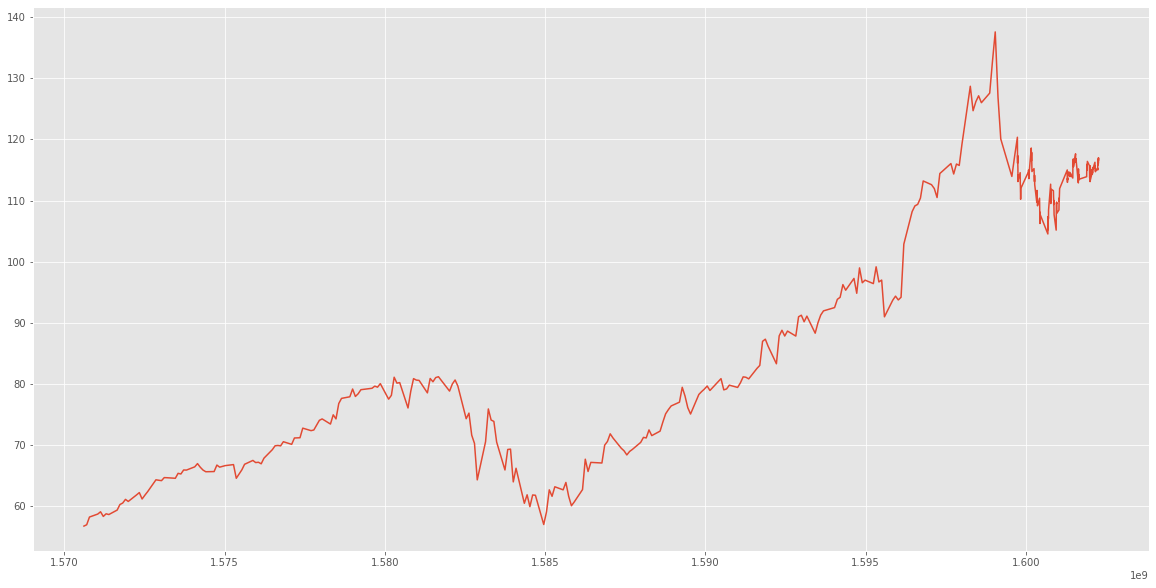

In [65]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(20,10))
plt.plot(data["timestamp"].values, data["open"].values)
plt.show()

In [37]:
X, y = data.iloc[:,0], data.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [73]:
# Spot-Check Algorithms
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' KNN ', KNeighborsRegressor()))
models.append((' CART ', DecisionTreeRegressor()))
models.append((' SVR ', SVR()))
models.append((' GBDT ', GradientBoostingRegressor(n_estimators=500, random_state=42)))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=9, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train.values.reshape(-1,1), y_train, cv=kfold, scoring='r2')
    # print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

 LR : 0.894927 (0.017186)
 LASSO : 0.894927 (0.017186)
 EN : 0.894927 (0.017186)
 KNN : 0.995470 (0.002869)
 CART : 0.996030 (0.001839)
 SVR : 0.958261 (0.013181)
 GBDT : 0.996316 (0.001789)


In [74]:
model = GradientBoostingRegressor(n_estimators=500, random_state=42)
model.fit(X_train.values.reshape(-1,1), y_train)
y_pred = model.predict(X_test.values.reshape(-1,1))
print(r2_score(y_test,y_pred))

0.9962548358038552


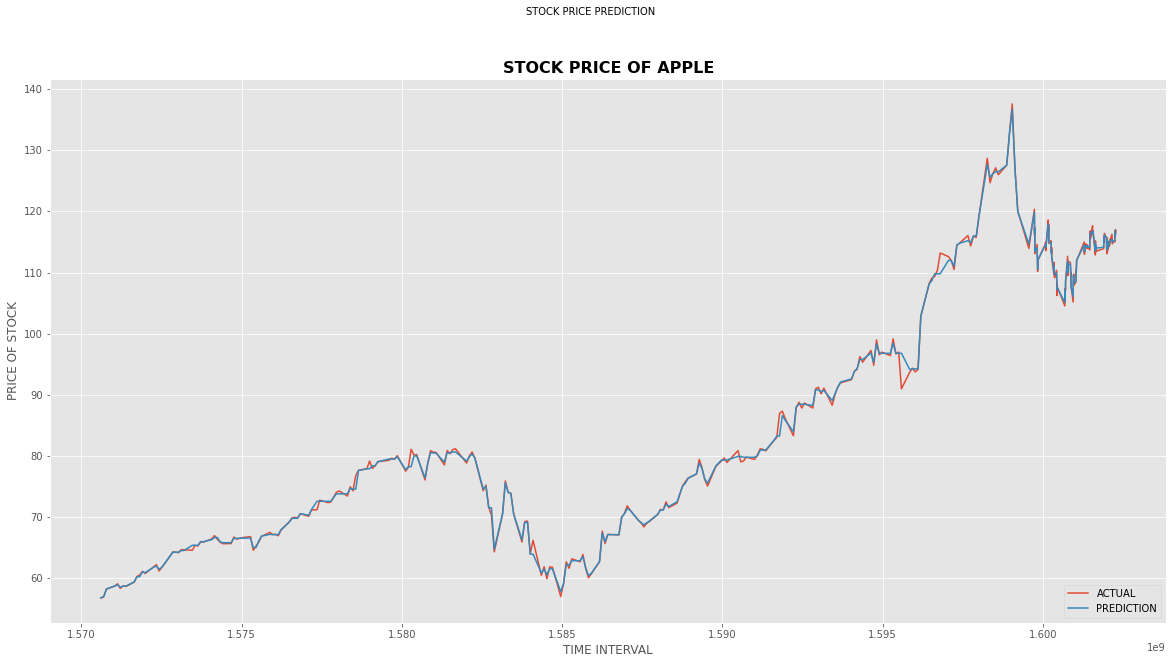

In [75]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(20,10))
plt.plot(X.values, y.values, label="ACTUAL")
plt.plot(X.values, model.predict(X.values.reshape(-1,1)), label="PREDICTION")
plt.legend(loc='lower right')
plt.title("STOCK PRICE OF APPLE", fontsize=16, fontweight='bold')
plt.suptitle("STOCK PRICE PREDICTION", fontsize=10)
plt.xlabel("TIME INTERVAL")
plt.ylabel("PRICE OF STOCK")
plt.show()